# **AdvStat4PhysAna - RLab 6**

**Barone Francesco Pio**, student ID: 2058478

19 may 2022

In [1]:
library(rjags)
options(repr.plot.width=7, repr.plot.height=6)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



<a id='exr1'></a>
## **EXR01** - Test for blood disease

In [2]:
p <- 15/100  # test failure rate (false negatives) of old test
n <- 75      # numof screened patients with disease in new test

**a |** What is the probability distribution of $y$, the number of times the new method fails to detect the disease?

Since the outcome of the test is binary (either you have the disease, or not) the process is bernoullian, so I assign a Binomial distribution.

<br><br>**b |** On the $n=75$ patients sample, the new method fails to detect the disease in $y=6$ cases. What is the frequentist estimator of the failure probability of the new method?

Simply, $$p_F = \frac{y}{n} = 0.08 $$

$$\text{Var}(p_F) = \frac{p(1-p)}{n} = 9.81\cdot10^{-4}$$

$$MSE[p_F] = 0 + \text{Var}(p_F) = 9.81\cdot10^{-4}$$

In [3]:
y <- 6   # numof failures with new test

pp <- y/n     # frequentist estimator
pp*(1-pp)/n   # frequentist variance

[1] 0.0009813333

<br><br>**c |** Setup a bayesian computation of the posterior probability, assuming a beta distribution (...). Plot the posterior distribution for $y$, and mark on the plot the mean value and variance.

With some handy calculations we can invert the known formulas of the Beta distribution parameters:
$$\alpha = (1-\mu)\frac{\mu}{\sigma^2}-\mu$$
$$\beta = \alpha\left(\mu^{-1}-1\right)$$

In [4]:
# given statistics of beta distribution
mu  <- 0.15
std <- 0.14

# let's go to a & b
alpha <- (1-mu)*(mu/std)^2 - mu
beta  <- alpha*((1/mu) - 1)
cat(alpha, beta)

0.8257653 4.679337

In [5]:
# generating p samples
dpp <- 0.0001  
ps <- seq(dpp, 1, dpp)  


######### PATH 1: numerically #########
# prior is the beta distribution (statistics of first blood test)
prior <- dbeta(ps, shape1=alpha, shape2=beta) 
# likelihood is the binomial given y and n (statistics of new blood test)
likel <- dbinom(x = y, size = n, prob = ps)
# & as usual, the posterior is ...
post <- prior*likel
post <- post/(sum(post)*dpp)  # (normalize)


######### PATH 2: analitically #########
# Binomial likel. + Beta prior ==> Beta conjugate distribution!
a.prime <- alpha + y
b.prime <- beta + n - y
post <- dbeta(ps,a.prime,b.prime)


# ... from which we compute mean and st. deviation as...
post.mean <- a.prime/(a.prime + b.prime)
post.std  <- sqrt( a.prime*b.prime/(((a.prime+b.prime)**2)*(a.prime+b.prime+1)) )
cat(post.mean, post.std)

0.08478674 0.03085551

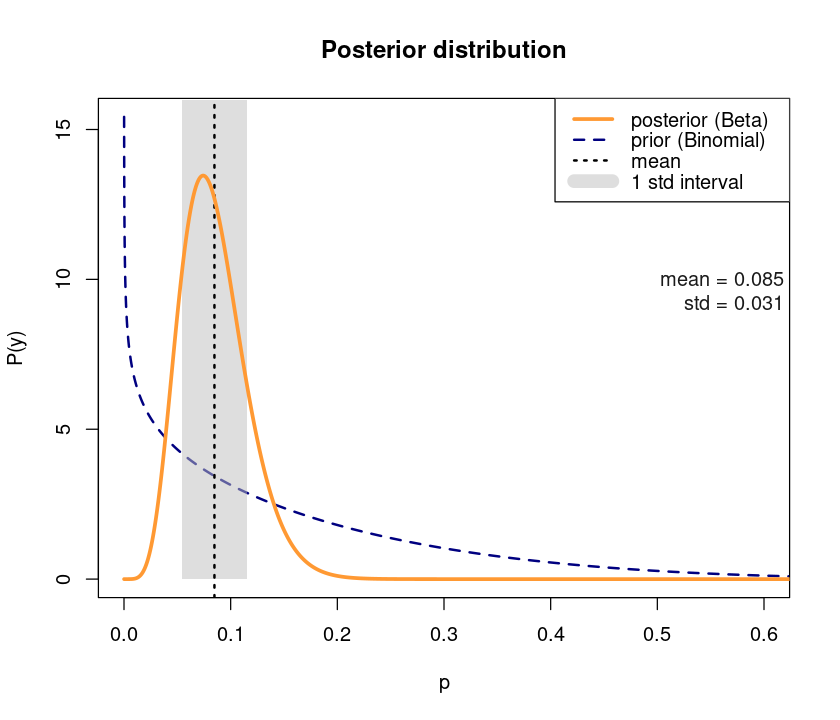

In [6]:
# plotting (order is messed up because of aesthetics)
plot(ps, prior, type="l", lwd=2, lty=2, col="navy", xlab='p', ylab="P(y)",
     xlim = c(0, 0.6),  main='Posterior distribution')
area.sx <- post.mean-post.std;   area.dx <- post.mean+post.std;
polygon( c(area.sx, area.dx, area.dx, area.sx),
         c(0,0,16,16), col=adjustcolor("grey",alpha.f=0.5), border=NA)
abline(v=post.mean, col="black", lty=3, lwd=2)
lines(ps, post, type="l", lwd=3, col="#FF9933")

# plot info
legend('topright', legend = c("posterior (Beta)", "prior (Binomial)", "mean", "1 std interval"), 
       col = c("#FF9933", "navy", "black", adjustcolor("grey", alpha.f=.5)), 
       lty=c(1,2,3,1), lwd = c(3,2,2,11) )
mtext(paste("mean =", round(post.mean,3), '\nstd =', round(post.std,3),''), 
      3, adj=1, line=-9, col = "grey10")

In [7]:
numinterval.one_side <- function(distr, dp, alpha, ps = NULL, side.left = TRUE, inclusive = TRUE, verbose = FALSE) {
    if(is.null(ps)) ps <- seq(0, length(distr))
    
    i <- 0;  sums <- 0;
    if(side.left) {
        if(verbose) cat('compute L side')
        limit <- alpha
    } else {
        if(verbose) cat('compute R side')
        limit <- 1-alpha
    }
    
    while(sums < limit) {  i<-i+1;  sums <- sums + dp*distr[i]; }
    sig.idx <- i - ifelse(inclusive, 0, 1)
    sig.p <- ps[sig.idx]
    sig <- sums - ifelse(inclusive, 0, dp*distr[i])        
    if(verbose) cat(ifelse(side.left,'left','right'), 'limit @', 
                    sig.idx,'| area:', sig,'| p:', sig.p, '\n')
    
    return( list(side.left = side.left, inclusive = inclusive, 
                 alpha = sig, idx = sig.idx, p = sig.p )
          )
    # notes on inclusive
    # not inclusive -->   [0, sig.idx[
    #     inclusive -->   [0, sig.idx]
}

In [8]:
# because I need it later, let us evaluate the 95% interval
post_norm <- post/sum(dpp*post)

nios <- numinterval.one_side(post_norm, dpp, 0.025, ps, inclusive = FALSE)
leftlimit <- nios$p
left.alpha <- nios$alpha

nios <- numinterval.one_side(post_norm, dpp, 0.025, ps, side.left = FALSE, inclusive = FALSE)
rightlimit <- nios$p

cat('95% interval:', leftlimit, rightlimit)
cat('\narea:', nios$alpha - left.alpha)

95% interval: 0.0346 0.1541
area: 0.9501279

<br><br>**d |** Perform a test of hypothesis assuming that if the probability of failing to the detect the desease in ill patients is greater or equal than $15\%$, the new test is no better that the traditional method. Test the sample at a $5\%$ level of significance in the Bayesian way.

I set the null hypotesis
$$H_0 : p_0 \geq 0.15 \;\;\;\text{(test is not better than previous)}$$ and the alternative hypotesis $$H_1:p<0.15 \;\;\;\text{(test is better than previous)}$$
<br>

In the **Bayesian** approach I evaluate $P(H_0|\text{posterior})$ (i.e. the integral from 0.15 to 1, in this case) and compare it with the significance $\alpha = 5\%$. The null hypotesis is rejected ($=$ there is evidence that the test is better) if $P(H_0|\text{posterior}) < \alpha$.

In [9]:
# significance test parameters:
p.test <- 15/100     # H_0 : p greater than 15%
signif <-  5/100

In [10]:
# NOTE | compute an integral, the R-easy way:
post.asfunction <- function(p) { dbeta(p,a.prime,b.prime) }
integrate(post.asfunction, p.test, 1)  # use $value to retrieve integral

0.03127933 with absolute error < 8.2e-07

In [11]:
# (back to the exr)

p.star <- integrate(post.asfunction, p.test, 1)$value
cat( paste('p* =', round(p.star*100,4), '%\n') )

# test result
if(p.star < signif) {
    # result is not due to chance
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
} else {
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
}

p* = 3.1279 %
Null hypotesis is rejected at significance 5 %


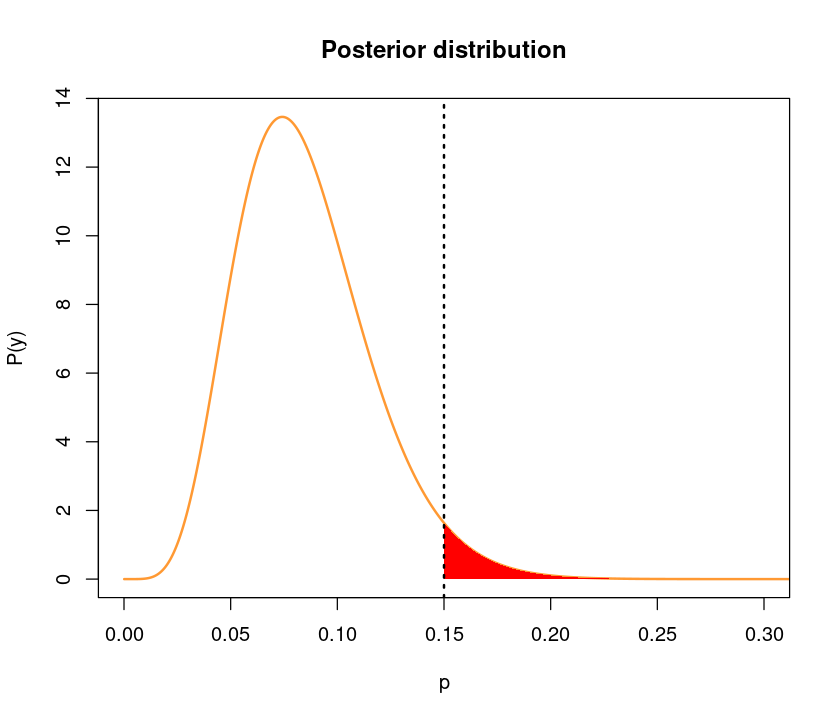

In [12]:
# visualize the situation
post.totest <- post.asfunction(ps)
plot(ps, post.totest, type="l", lwd=2, col="#FF9933", xlab='p', ylab="P(y)",
     xlim = c(0, 0.3),  main='Posterior distribution')
polygon( c( p.test, ps[ps>=p.test]),
         c( 0, post.totest[ps>=p.test]), col="red", border=NA)
abline(v=p.test, col="black", lty=3, lwd=2)

Therefore $p$ is greater than $0.15$ with probability $3.128\%$ (i.e. the red area), so we **reject** the Null hypotesis (with significance of $5\%$): the test is better than the previous.

<br><br>**e |** Perform the same hypothesis test in the classical **frequentist** way.

In [13]:
# frequentist way
p.value <- sum( dbinom( seq(0, y, 1), size=n, p=p.test) ) 
cat( paste('p-value =', round(p.value*100,4), '%\n') )
# in the frequentist approach we work on the likelihood: dbinom(x, n = 75, p = 0.15)

# test result
if(p.value < signif) { 
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
} else {
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
}

p-value = 5.4353 %
Null hypotesis cannot be rejected at significance 5 %


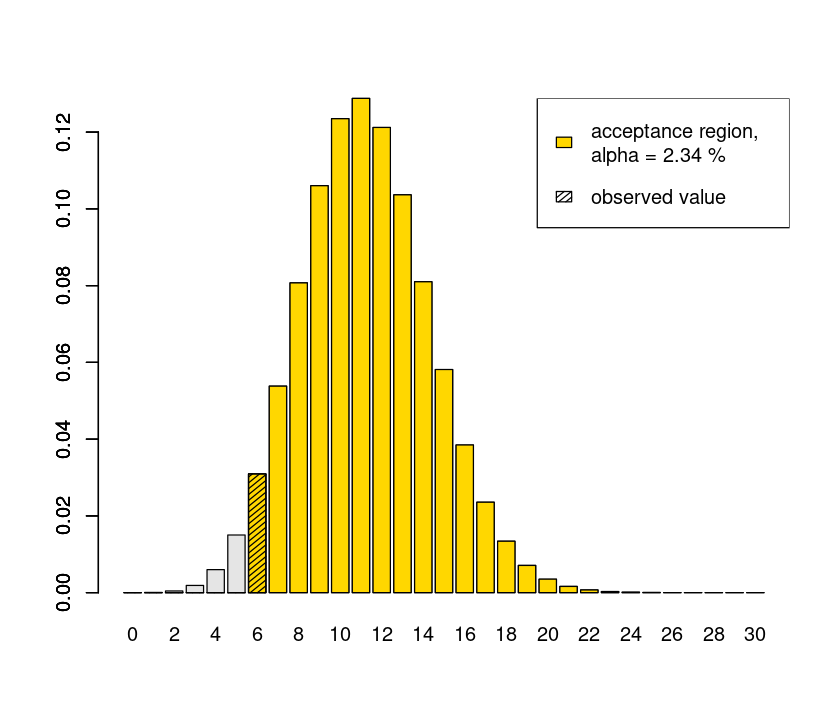

In [14]:
# frequentist way (one sided)
# this is tricky, so I prefer to visualize the situation

ys <- seq(0, 30, 1)
distr.fr <- dbinom(ys, size=n, p=p.test)
barplot(distr.fr, col='grey90', names.arg=ys)

# compute the closest significance
nios <- numinterval.one_side(distr.fr, 1, 0.05, ys, inclusive=FALSE)
closest_sig <- nios$alpha
closest_sig_idx <- nios$idx
closest_sig_p <- nios$p

# highlight acceptance region
barplot( c(rep(0,closest_sig_idx), distr.fr[closest_sig_idx+1:length(ys)]), col='gold', add=TRUE)

# highlight observed value
barplot( c(rep(0,y), distr.fr[y+1]), col='black', density=25, add=TRUE)

legend("topright", 
       legend = c( paste("acceptance region, \nalpha =", round(closest_sig*100,2), "%"), "observed value"), 
       fill = c("gold", "black"), density=c(NA,25), y.intersp=2)

We see that the observed value falls inside the acceptance region, $\Rightarrow$ we **cannot reject** the null hypotesis (so the test is not better).

There is another way to figure this out, using the p-value:

In [15]:
# alternatively
binom.test(x = 6, n = n, p = p.test, 
           #  y=6 fails over n=75 patients, p.test=15%
           alternative = "less", conf.level = 0.95)
           #   ^ alternative hyp (H_1) is < (less) than p.test


	Exact binomial test

data:  6 and n
number of successes = 6, number of trials = 75, p-value = 0.05435
alternative hypothesis: true probability of success is less than 0.15
95 percent confidence interval:
 0.0000000 0.1517971
sample estimates:
probability of success 
                  0.08 


Since p-value > $\alpha$, we **cannot reject** $H_0$ ($\Rightarrow$ the test is not better).

<br><br><br><a id='exr4'></a>
## **EXR04** - Disease in blood (with MCMC)

Analyze the data of **EXR1** using a MCMC with JAGS (solve only *point a*).

In [16]:
# create a data vector with 75 values, 6 of which are ones (failures)
obs_data <- c( rep(1,y), rep(0,n-y) )

In [17]:
jdata <- NULL
jdata$X <- obs_data
jdata$n <- length(obs_data)
jdata$n_next <- 10  # not required in exr

In [18]:
jm <- jags.model('exr04.bug', jdata)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 80

Initializing model



In [19]:
update(jm, 1000)
chain <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain))


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0905837      0.0324130      0.0003241      0.0003241 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.03821 0.06730 0.08722 0.10993 0.16324 



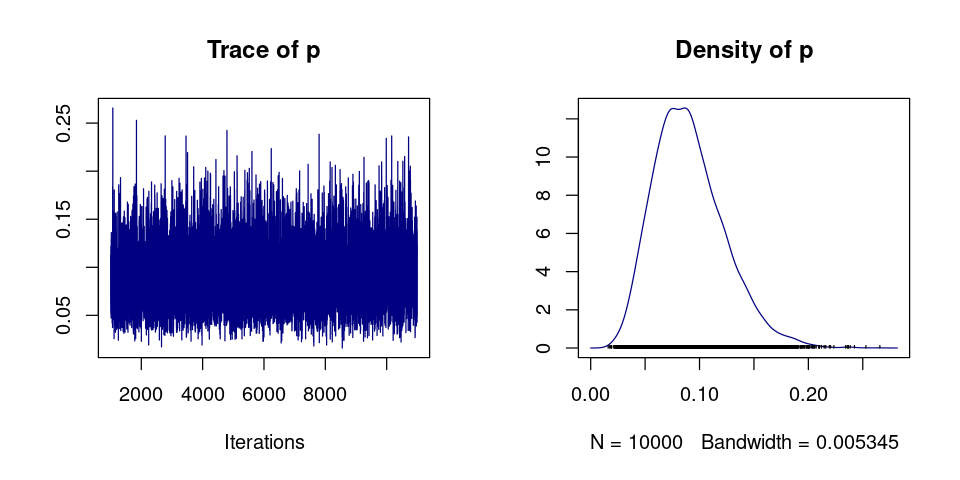

In [20]:
options(repr.plot.width=8, repr.plot.height=4)
plot(chain, col="navy")

# format as dataframe
chain.df <- as.data.frame( as.mcmc(chain) )

Comparing the results from the previous EXR (c) with MCMC:

|  | analytic bayesian | MCMC |
| --: | :-: | :-: |
| best est | 0.085 | 0.091 |
| 95% credible interval | \[0.035, 0.154\] | \[0.039, 0.164\] |

<br><br><br><a id='exr2'></a>
## **EXR02** - Horse kicking the Prussian army

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution. Consider the following set of obstervations (...):

| $y$ death soldiers | 0 | 1 | 2 | 3 | 4 | ≥5 |
| --- | --- | --- | ---| ---| ---| ---|
|$n_1$ observations |109 |65 |22 |3 |1 |0|
|$n_2$ observations | 144 |91 |32 |11 |2 |0|

In [21]:
n_1 <- c(109, 65, 22, 3, 1, 0)
n_2 <- c(144, 91, 32, 11, 2, 0)

The exercise is:
- compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time.
- determine the posterior mean, median and variance, and compute the $95\%$ credibility interval.

Do this assuming **(a)** a uniform prior, **(b)** Jeffreys' prior $g(\lambda) ∝ \frac{1}{\sqrt\lambda}$ , with $\lambda > 0$.

In [22]:
# this functions will come handy!

numerical_median <- function(pdistr, p, dp) {
    integral <- 0.0;   i <- 0;
    while(integral < 0.5) {
        i <- i+1
        integral <- integral + dp*pdistr[i]
    }
    return(p[i-1])
}

posterior.poisson_process <- function(y, prior = 'uniform', limx = c(20,80), dx = 0.005, conf = 0.05) {
    if(prior=='uniform')
        post.alpha = sum(y) + 1
    else if(prior=='jeffreys')
        post.alpha = sum(y) + 1/2
    else {
        cat('ERR, unknown prior')
        return(1)
    } 
    post.lambda = length(y)
    
    dmu <- dx;       mu <- seq( limx[1], limx[2], dmu);
    post <- dgamma(shape = post.alpha, rate = post.lambda, mu)
    
    # compute statistics
    mean <- post.alpha/post.lambda
    var  <- post.alpha/(post.lambda^2)
    median <- numerical_median(post, mu, dmu)
    
    # compute credibility interval
    q_lower <- qgamma(conf/2, shape = post.alpha, rate = post.lambda)
    q_upper <- qgamma(1 - conf/2, post.alpha, post.lambda)
    
    # return everything
    return( list( alpha = post.alpha, lambda = post.lambda,
                  post = post, mu = mu, prior = prior,
                  mean = mean, var = var, std = sqrt(var), 
                  median = median, conf = c(q_lower, q_upper)
                )
          )
}

print_stats <- function(lst, header = '') {
    cat(paste('++++++',header,'++++++\n'))
    cat(paste(' Assuming prior:',lst$prior,'\n'))
    cat(paste0(' Posterior is Gamma(', lst$alpha,',', lst$lambda,')\n'))
    cat( paste('mean:', lst$mean, '  median:', lst$median, '  std:', lst$std, '\n') )
    cat(paste('credible interval 95%: [', 
          round(lst$conf[1],4), ',', round(lst$conf[2],4),']') )
    cat('\n\n')
}

<br><br>**a |** uniform prior

In this case the posterior is $\text{Gamma}(\alpha, \lambda)$, with $\alpha = \sum y_i + 1$ and $\lambda = n$.

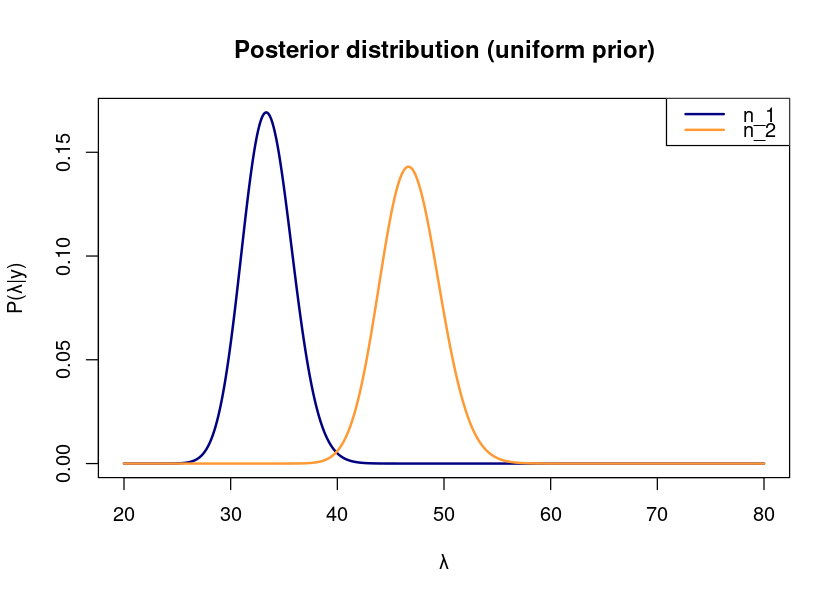

In [23]:
options(repr.plot.width=7, repr.plot.height=5)
post.unif.n1 <- posterior.poisson_process(n_1, prior = 'uniform')
post.unif.n2 <- posterior.poisson_process(n_2, prior = 'uniform')

plot(post.unif.n1$mu, post.unif.n1$post, type="l", lwd=2, col="navy", xlab='λ', ylab="P(λ|y)",
     main='Posterior distribution (uniform prior)')
lines(post.unif.n2$mu, post.unif.n2$post, type="l", lwd=2, col="#FF9933")
legend('topright', legend = c("n_1", "n_2"), 
       col = c("navy", "#FF9933"), lwd = 2 )

In [24]:
print_stats(post.unif.n1, header='n1 dataset')
print_stats(post.unif.n2, header='n2 dataset')

++++++ n1 dataset ++++++
 Assuming prior: uniform 
 Posterior is Gamma(201,6)
mean: 33.5   median: 33.44   std: 2.3629078131263 
credible interval 95%: [ 29.0286 , 38.287 ]

++++++ n2 dataset ++++++
 Assuming prior: uniform 
 Posterior is Gamma(281,6)
mean: 46.8333333333333   median: 46.775   std: 2.7938424357067 
credible interval 95%: [ 41.517 , 52.4653 ]



<br><br>**b |** Jeffreys' prior

In this case the posterior is $\text{Gamma}(\alpha, \lambda)$, with $\alpha = \sum y_i + \frac{1}{2}$ and $\lambda = n$.

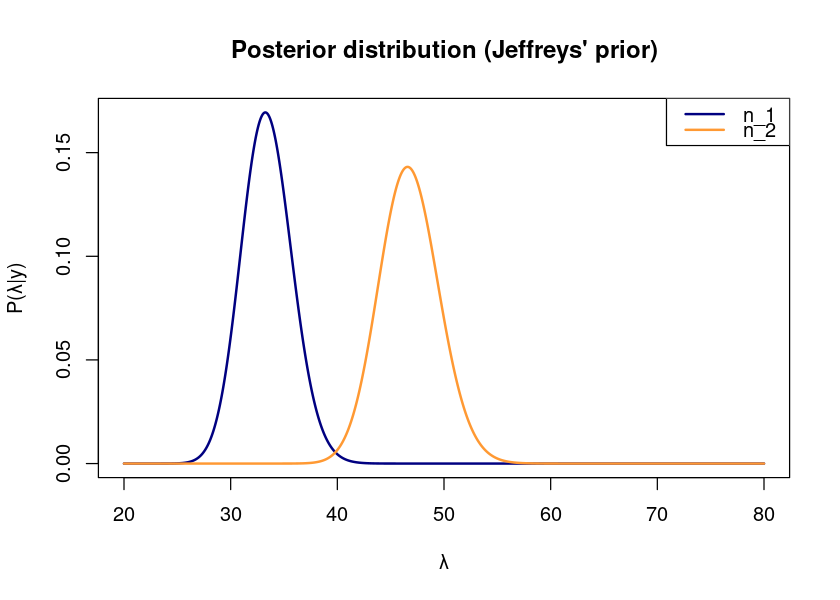

In [25]:
post.jef.n1 <- posterior.poisson_process(n_1, prior = 'jeffreys')
post.jef.n2 <- posterior.poisson_process(n_2, prior = 'jeffreys')

plot(post.jef.n1$mu, post.jef.n1$post, type="l", lwd=2, col="navy", xlab='λ', ylab="P(λ|y)",
     main='Posterior distribution (Jeffreys\' prior)')
lines(post.jef.n2$mu, post.jef.n2$post, type="l", lwd=2, col="#FF9933")
legend('topright', legend = c("n_1", "n_2"), 
       col = c("navy", "#FF9933"), lwd = 2 )

In [26]:
print_stats(post.jef.n1, header='n1 dataset')
print_stats(post.jef.n2, header='n2 dataset')

++++++ n1 dataset ++++++
 Assuming prior: jeffreys 
 Posterior is Gamma(200.5,6)
mean: 33.4166666666667   median: 33.355   std: 2.35996704308438 
credible interval 95%: [ 28.951 , 38.1979 ]

++++++ n2 dataset ++++++
 Assuming prior: jeffreys 
 Posterior is Gamma(280.5,6)
mean: 46.75   median: 46.69   std: 2.79135570407404 
credible interval 95%: [ 41.4386 , 52.3771 ]



<br><br><br><a id='exr5'></a>
## **EXR05** - Horse kicking the Prussian army (with MCMC)

Analyze the data of **EXR2** using a MCMC with JAGS.

For this EXR I will use only the set of observations n_1. It works also for n_2, of course.

In [27]:
jdata <- NULL
jdata$X <- n_1 # set of observations
jdata$n <- length(n_1)

In [28]:
jm <- jags.model('exr05.bug', jdata)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 2
   Total graph size: 10

Initializing model



In [29]:
update(jm, 1000)   # burn-in

chain <- coda.samples(jm, c("lambda", "Y"), n.iter=10000)
print(summary(chain))


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean    SD Naive SE Time-series SE
Y      33.54 6.272  0.06272        0.06132
lambda 33.52 2.369  0.02369        0.02369

2. Quantiles for each variable:

        2.5%   25%   50%   75% 97.5%
Y      22.00 29.00 33.00 38.00 46.00
lambda 29.03 31.93 33.48 35.06 38.31



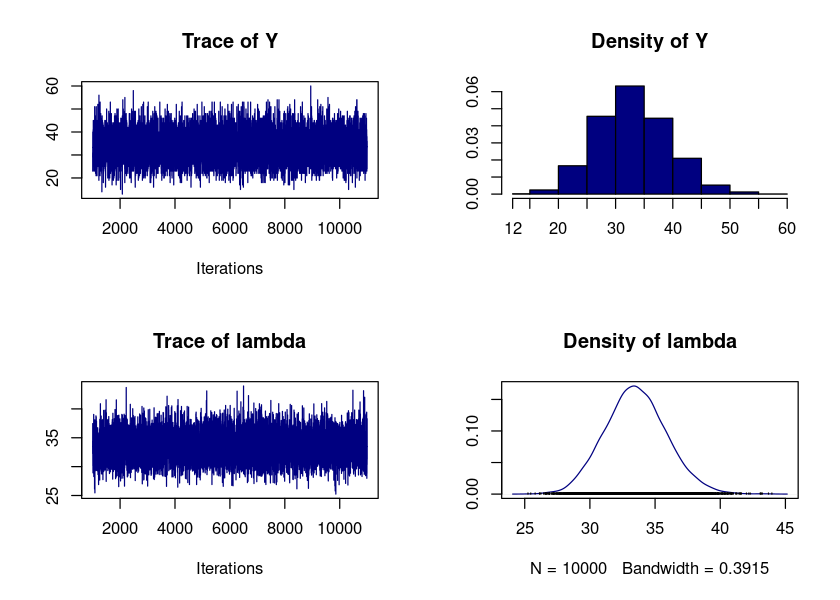

In [30]:
options(repr.plot.width=7, repr.plot.height=5)
plot(chain, col="navy")

Comparing the results from the previous EXR with MCMC, just for the case of the **uniform prior**, we have:

|  | analytic bayesian | MCMC |
| --: | :-: | :-: |
| best est | 33.5 | 33.49 |
| 95% credible interval | \[29.03 , 38.29\] | \[29.03, 38.28\] |

<br><br><br><a id='exr3'></a>
## **EXR03** - Bacteria in streams

A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level.

In [31]:
n <- 116  # nof samples
y <- 11   # nof samples with high bacteria

<br><br>**a |** find the frequentist estimator for $p$

In [32]:
p.freq <- y/n
p.var.freq <- p.freq*(1-p.freq)/n   # variance

cat(p.freq)

0.09482759

<br><br>**b |** using a $Beta(1,10)$ prior for $p$, calculate and posterior distribution $P(p∣y)$

In [33]:
# beta prior ==> posterior is Beta
a.prime <- 1 + y
b.prime <- 10 + n - y
post <- dbeta(ps,a.prime,b.prime)

<br><br>**c |** find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval

In [34]:
bay.best_est <- (y+a.prime-1)/(n+a.prime+b.prime-2)
bay.best_std <- sqrt( (y+a.prime-1)/(a.prime+y) )/(n+a.prime+b.prime-2)
bay.best_var <- bay.best_std^2

cat( paste('best_est:', bay.best_est, ', var:',bay.best_var, '\n') )

conf <- 0.05 # for 95%
q_lower <- qbeta(conf/2, shape1 = a.prime, shape2 = b.prime)
q_upper <- qbeta(1 - conf/2, shape1 = a.prime, shape2 = b.prime)

cat( paste('confidence interval: [', q_lower, ',', q_upper, ']\n') )

best_est: 0.0912863070539419 , var: 1.64687546552304e-05 
confidence interval: [ 0.0501852163002454 , 0.150837921271285 ]


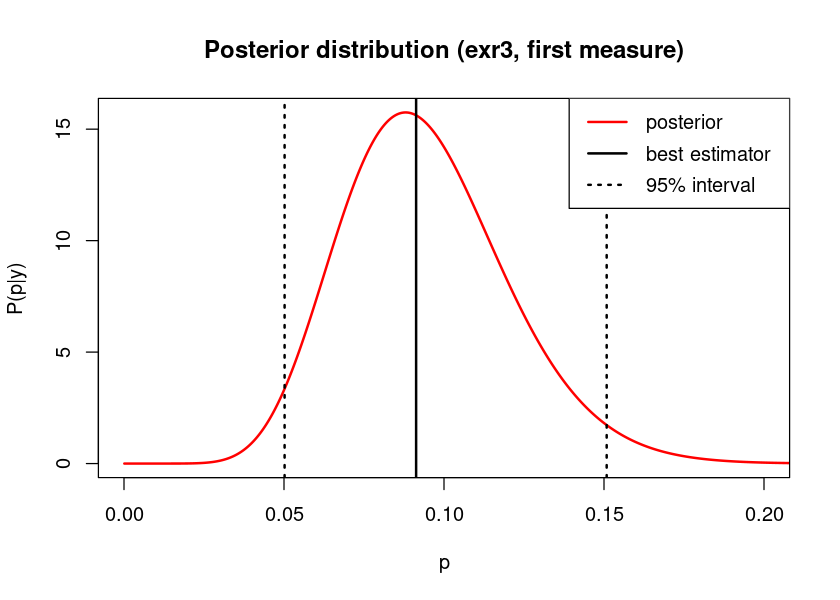

In [35]:
# let's visualize the situation
options(repr.plot.width=7, repr.plot.height=5)
plot(ps, post, type="l", lwd=2, col="red", xlab='p', ylab="P(p|y)",
     xlim = c(0, 0.2),  main='Posterior distribution (exr3, first measure)')
abline(v=bay.best_est, col="black", lwd=2)
abline(v=q_lower, col="black", lty=3, lwd=2)
abline(v=q_upper, col="black", lty=3, lwd=2)

legend('topright', legend = c("posterior", "best estimator", "95% interval"), 
       col = c("red", "black", "black"), 
       lty=c(1,1,3), lwd = 2, y.intersp=2 )

<br><br>**d |** test the hypotesis $$H_0 : p = 0.1 \;\;\;\text{vs}\;\;\; H_1 : p \neq 0.1$$
at $5\%$ level of significance with both the frequentist and bayesian approach

In [36]:
# significance (two sided) test parameters
p.test <- 1/10
signif <- 5/100

**FREQUENTIST**

In [37]:
# for the frequentist approach I need this:
numinterval.two_side <- function(distr, alpha, ps = NULL, verbose = FALSE) {
    
    if(is.null(ps)) ps <- seq(0, length(distr))
    
    i <- 0;  sums <- 0;
    
    # lower limit
    while(sums < alpha/2)   {  i<-i+1;  sums <- sums + distr[i]; }
    low_sig.idx <- i              # loop index
    low_sig.p <- ps[low_sig.idx]  # corresponding p
    low_sig <- sums - distr[i]    # area to the left of idx
    if(verbose)  cat(' lower limit @', low_sig.idx,'| area:', low_sig,'| p:', low_sig.p, '\n')
    
    # upper limit
    while(sums < 1-alpha/2) {  i<-i+1;  sums <- sums + distr[i]; }
    upp_sig.idx <- i;   upp_sig.p <- ps[upp_sig.idx];
    upp_sig <- sums;   # area up to the higher limit
    if(verbose)  cat(' upper limit @', upp_sig.idx,'| area:', upp_sig,'| p:', upp_sig.p, '\n')
    
    return( list(alpha = low_sig + 1 - upp_sig,
                 # ^^^ return    area [0, low.idx[  U  ]upp.idx, inf[
                 low.idx = low_sig.idx, low.area = low_sig, low.p = low_sig.p,
                 # ^^^      left index (non inclusive) + area [0, low.idx[ + corresp. prob. value
                 upp.idx = upp_sig.idx, upp.area = upp_sig, upp.p = upp_sig.p
                 # ^^^      right index (inclusive) + area [0, upp.idx] + corresp. prob. value
                )
          )
}

closest significance:  0.0425434770929675 


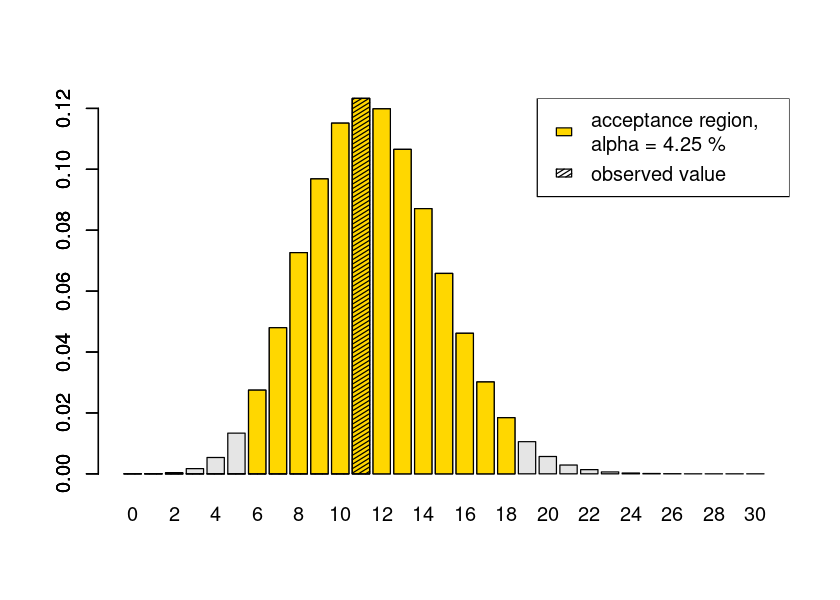

In [38]:
# frequentist way (two sided)
# this is tricky, so I prefer to visualize the situation

ys <- seq(0, 30, 1)
distr.fr <- dbinom(ys, size=n, p=p.test)
barplot(distr.fr, col='grey90', names.arg=ys)

# compute the closest significance
nits <- numinterval.two_side(distr.fr,0.05,ys)
closest_sig <- nits$alpha
cat( paste('closest significance: ', closest_sig, '\n') )

# highlight acceptance region
barplot( c(rep(0,nits$low.idx-1), distr.fr[nits$low.idx:nits$upp.idx]), col='gold', add=TRUE)

# highlight observed value
barplot( c(rep(0,y), distr.fr[y+1]), col='black', density=25, add=TRUE)

legend("topright", 
       legend = c(paste("acceptance region, \nalpha =", round(closest_sig*100,2), "%"), 
                  "observed value"), 
       fill = c("gold", "black"), density=c(NA,25), y.intersp=2)

We observe that $y=11$ falls inside the acceptance region, $\Rightarrow$ we **cannot reject** the null hypotesis.

**BAYESIAN**

In [39]:
# Bayesian

# use the 95% credibility interval computed above
cat( paste('credibility interval: [', q_lower, ',', q_upper, ']\n') )

# test result
if( (q_lower < p.test) & (p.test<q_upper) ) {
    # p is inside confidence interval
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
} else { 
    # p is outside confidence interval
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
}

credibility interval: [ 0.0501852163002454 , 0.150837921271285 ]
Null hypotesis cannot be rejected at significance 5 %


<br><br><br>
A **new measurement**, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter X level.

In [40]:
#n <- 116 # (same as before)
y <- 9    # nof samples with high bacteria

# required later
old_meas.alpha <- a.prime
old_meas.beta <- b.prime

<br><br>**e |** find the frequentist estimator for $p$

In [41]:
p.freq <- y/n
p.var.freq <- p.freq*(1-p.freq)/n   # variance

cat(p.freq)

0.07758621

<br><br>**f |** find a bayesian estimator for $p$, assuming both a $Beta(1, 10)$ prior for $p$, and assuming the posterior
probability of the older measurement as the prior for the new one

In [42]:
# first answer: assume a Beta(1,10) prior
a.prime <- 1 + y
b.prime <- 10 + n - y
bay.best_est <- (y+a.prime-1)/(n+a.prime+b.prime-2)
bay.best_std <- sqrt( (y+a.prime-1)/(a.prime+y) )/(n+a.prime+b.prime-2)

cat(' +++ Beta(1,10) prior +++\n')
cat( paste(' best_est:', bay.best_est, ', std:',bay.best_std, '\n') )

 +++ Beta(1,10) prior +++
 best_est: 0.0746887966804979 , std: 0.00403870758001898 


In [43]:
# second answer: use as prior the older measurement
a.prime <- old_meas.alpha + y
b.prime <- old_meas.beta + n - y
bay.best_est <- (y+a.prime-1)/(n+a.prime+b.prime-2)
bay.best_std <- sqrt( (y+a.prime-1)/(a.prime+y) )/(n+a.prime+b.prime-2)

cat(' +++ old measure prior +++\n')
cat( paste(' best_est:', bay.best_est, ', std:',bay.best_std, '\n') )

 +++ old measure prior +++
 best_est: 0.0812324929971989 , std: 0.00275403944047668 


<br><br>**g |** find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval

In [44]:
post <- dbeta(ps,a.prime,b.prime)

#bay.best_est   calculated above
#bay.best_std   calculated above
bay.best_var <- bay.best_std^2
cat( paste('best_est:', bay.best_est, ', var:',bay.best_var, '\n') )

bay.mean <- (a.prime + y)/(a.prime+b.prime+n)
cat( paste('mean:', bay.mean, '\n') )

conf <- 0.05 # for 95%
q_lower <- qbeta(conf/2, shape1 = a.prime, shape2 = b.prime)
q_upper <- qbeta(1 - conf/2, shape1 = a.prime, shape2 = b.prime)

cat( paste('confidence interval 95%: [', q_lower, ',', q_upper, ']\n') )

best_est: 0.0812324929971989 , var: 7.58473323970111e-06 
mean: 0.0835654596100279 
confidence interval 95%: [ 0.054519478855277 , 0.124752637208708 ]


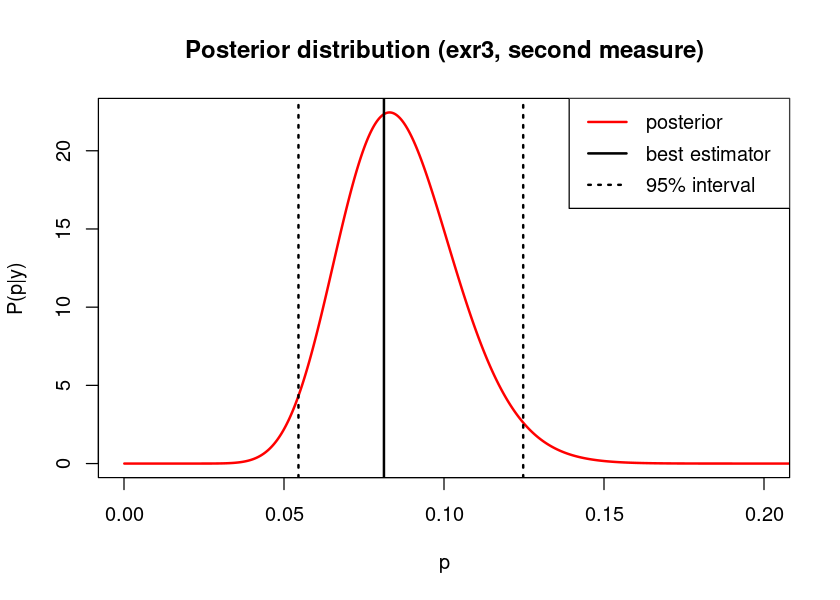

In [45]:
# let's visualize the situation
options(repr.plot.width=7, repr.plot.height=5)
plot(ps, post, type="l", lwd=2, col="red", xlab='p', ylab="P(p|y)",
     xlim = c(0, 0.2),  main='Posterior distribution (exr3, second measure)')
abline(v=bay.best_est, col="black", lwd=2)
abline(v=q_lower, col="black", lty=3, lwd=2)
abline(v=q_upper, col="black", lty=3, lwd=2)

legend('topright', legend = c("posterior", "best estimator", "95% interval"), 
       col = c("red", "black", "black"), 
       lty=c(1,1,3), lwd = 2, y.intersp=2)

<br><br>**h |** test the hypotesis $$H_0 : p = 0.1 \;\;\;\text{vs}\;\;\; H_1 : p \neq 0.1$$
at $5\%$ level of significance with both the frequentist and bayesian approach

In [46]:
# significance (two sided) test parameters
p.test <- 1/10
signif <- 5/100

**FREQUENTIST**

closest significance:  0.0425434770929675 


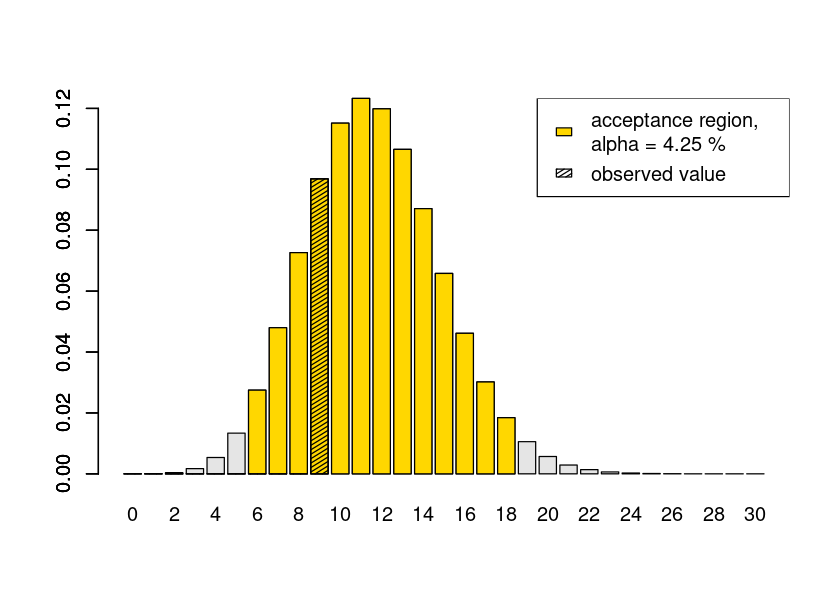

In [47]:
# frequentist way (two sided)
ys <- seq(0, 30, 1)
distr.fr <- dbinom(ys, size=n, p=p.test)
barplot(distr.fr, col='grey90' ,names.arg=ys)

# compute the closest significance
nits <- numinterval.two_side(distr.fr,0.05,ys)
closest_sig <- nits$alpha
cat( paste('closest significance: ', closest_sig, '\n') )

# highlight acceptance region
barplot( c(rep(0,nits$low.idx-1), distr.fr[nits$low.idx:nits$upp.idx]), col='gold', add=TRUE)

# highlight observed value
barplot( c(rep(0,y), distr.fr[y+1]), col='black', density=25, add=TRUE)

legend("topright", 
       legend = c(paste("acceptance region, \nalpha =", round(closest_sig*100,2), "%"),
                  "observed value"), 
       fill = c("gold", "black"), density=c(NA,25), y.intersp=2)

We observe that $y=9$ still falls inside the acceptance region, $\Rightarrow$ we **cannot reject** the null hypotesis.

**BAYESIAN**

In [48]:
# Bayesian

# use the 95% credibility interval computed above
cat( paste('credibility interval: [', q_lower, ',', q_upper, ']\n') )

# test result
if( (q_lower < p.test) & (p.test < q_upper) ) {
    # p is inside credible interval
    cat('Null hypotesis cannot be rejected at significance', round(signif*100,2),'%\n')
} else {
    # p is outside credible interval
    cat('Null hypotesis is rejected at significance', round(signif*100,2),'%\n') 
}

credibility interval: [ 0.054519478855277 , 0.124752637208708 ]
Null hypotesis cannot be rejected at significance 5 %


<br><br><br><a id='exr6'></a>
## **EXR06** - Bacteria in streams (with MCMC)

Analyze the data of EXR3 using a MCMC with JAGS (solve *point b* and *c*)

In [49]:
y <- 11 # for point b & c

# create a data vector
obs_data <- c( rep(1,y), rep(0,n-y) )

In [50]:
jdata <- NULL
jdata$X <- obs_data
jdata$n <- length(obs_data)
jdata$n_next <- 10  # not required in exr

In [51]:
jm <- jags.model('exr06.bug', jdata)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 2
   Total graph size: 122

Initializing model



In [52]:
update(jm, 1000)
chain <- coda.samples(jm, c("p"), n.iter=10000)
print(summary(chain))


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0946116      0.0259560      0.0002596      0.0002670 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.05023 0.07632 0.09225 0.11088 0.15184 



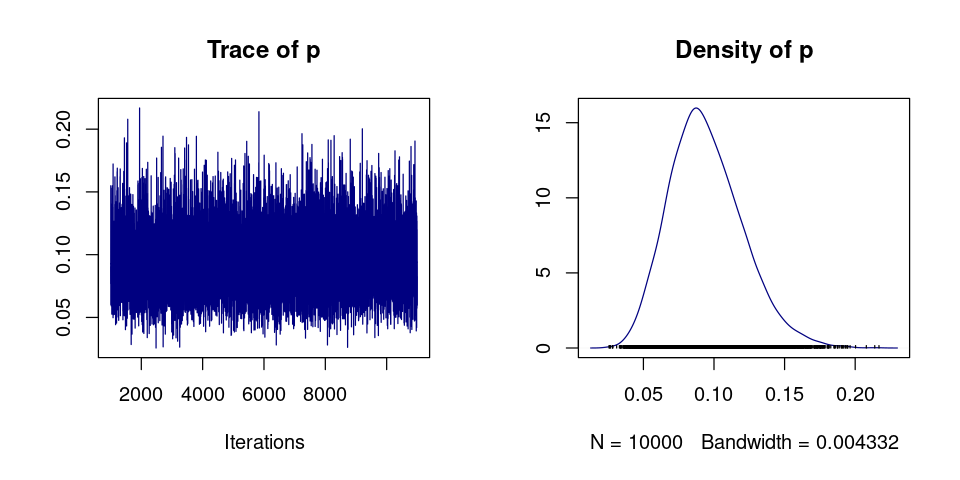

In [53]:
options(repr.plot.width=8, repr.plot.height=4)
plot(chain, col="navy")

# format as dataframe
chain.df <- as.data.frame( as.mcmc(chain) )

Comparing the results from the previous EXR (point b & c) with MCMC:

|  | analytic bayesian | MCMC |
| --: | :-: | :-: |
| best est | 0.091 | 0.095 |
| 95% credible interval | \[0.050, 0.151\] | \[0.050, 0.151\] |

End of file